[Encoder] Layer 0: in=3, out=32, size=256x256
[Encoder] Layer 1: in=32, out=64, size=128x128
[Encoder] Layer 2: in=64, out=128, size=64x64
[Encoder] Conv output: 128x64x64
[Encoder] Latent output: 4x64x64
[Decoder] Latent input: 4x64x64
[Decoder] Decoder start: 128x64x64
[Decoder] Layer 0: in=128, out=128, size=128x128
[Decoder] Layer 1: in=128, out=64, size=256x256
[Decoder] Layer 2: in=64, out=32, size=512x512
[Decoder] Final output: 3x512x512
Loaded config: {'unet': {'in_channels': 4, 'out_channels': 4, 'cond_channels': 0, 'base_channels': 64, 'depth': 3, 'num_res_blocks': 2, 'time_dim': 128, 'norm': 'batch', 'act': 'relu'}}
Starting sampling...
Step 0/200
Step 50/200
Step 100/200
Step 150/200
Sampling complete!

Sampled latent - min: nan, max: nan, mean: nan, std: nan
Real latent - min: -2.5352, max: 6.8890, mean: -0.1075, std: 1.4180

Decoding...
Images - min: nan, max: nan


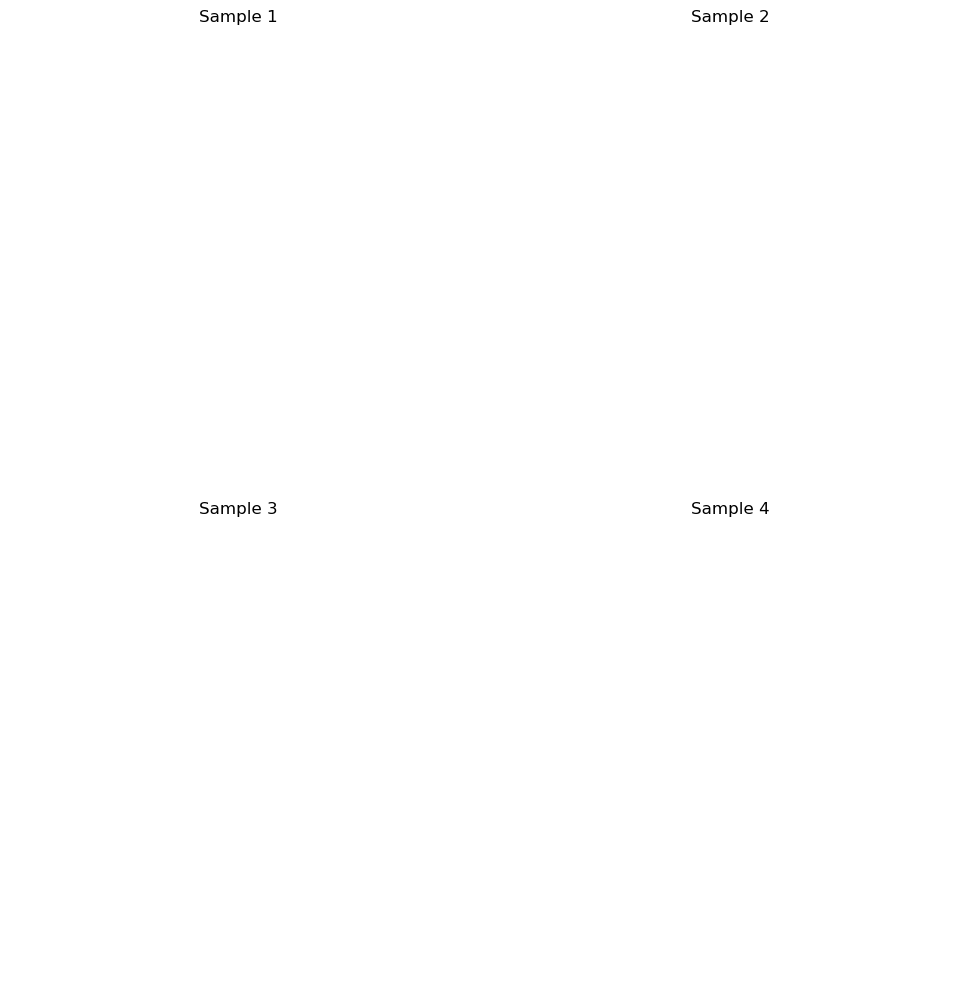

In [ ]:
import sys
sys.path.append(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav")

import torch
import yaml
import matplotlib.pyplot as plt
from modules.autoencoder import AutoEncoder
from modules.unet import UNet
from modules.scheduler import CosineScheduler

# Load autoencoder
autoencoder = AutoEncoder.from_config(
    r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\indexes\ae_configs\config_diff_4ch_64x64_vanilla.yml"
)
autoencoder.load_state_dict(torch.load(
    r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\indexes\autoencoder_final_64x64x4_vanila\20251004-082051_ae_final\best.pt",
    map_location='cpu'
))
autoencoder.eval()

# Load U-Net config manually
with open(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\config\base_unet_small.yml", 'r', encoding='utf-8') as f:
    unet_cfg = yaml.safe_load(f)
    print("Loaded config:", unet_cfg)  # Debug

# Create U-Net
unet = UNet(**unet_cfg['unet'])

# Load checkpoint
# checkpoint = torch.load(
#     r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\indexes\best.pt",
#     map_location='cpu'
# )
unet = UNet(**unet_cfg['unet'])
unet.eval()

print("WARNING: Using untrained U-Net - results will be random noise")

# Scheduler
scheduler = CosineScheduler(num_steps=200)

# Sample latents
device = 'cpu'
latent_shape = (4, 64, 64)
x_t = torch.randn(4, *latent_shape, device=device)

timesteps = torch.linspace(199, 0, 200, dtype=torch.long)

print("Starting sampling...")
with torch.no_grad():
    for i, t in enumerate(timesteps):
        if i % 50 == 0:
            print(f"Step {i}/200 - latent range: [{x_t.min():.4f}, {x_t.max():.4f}]")
            
        t_batch = torch.full((4,), t, device=device, dtype=torch.long)
        noise_pred = unet(x_t, t_batch, cond=None)
        
        alpha_bar = scheduler.alpha_bars[t].item()  # Get scalar value
        
        if t > 0:
            alpha_bar_prev = scheduler.alpha_bars[t - 1].item()
            beta = scheduler.betas[t].item()
            
            # Add epsilon for numerical stability
            eps = 1e-8
            sqrt_alpha_bar = torch.sqrt(torch.tensor(alpha_bar) + eps)
            sqrt_one_minus = torch.sqrt(torch.tensor(1 - alpha_bar) + eps)
            
            pred_x0 = (x_t - sqrt_one_minus * noise_pred) / sqrt_alpha_bar
            pred_x0 = torch.clamp(pred_x0, -10, 10)  # Clamp to prevent explosion
            
            sqrt_alpha_bar_prev = torch.sqrt(torch.tensor(alpha_bar_prev) + eps)
            sigma = torch.sqrt(torch.tensor(beta) + eps)
            noise = torch.randn_like(x_t)
            
            x_t = (
                sqrt_alpha_bar_prev * pred_x0 +
                torch.sqrt(torch.tensor(1 - alpha_bar_prev - sigma**2).clamp(min=0) + eps) * noise_pred +
                sigma * noise
            )
        else:
            eps = 1e-8
            sqrt_alpha_bar = torch.sqrt(torch.tensor(alpha_bar) + eps)
            sqrt_one_minus = torch.sqrt(torch.tensor(1 - alpha_bar) + eps)
            x_t = (x_t - sqrt_one_minus * noise_pred) / sqrt_alpha_bar
        
        # Check for NaN
        if torch.isnan(x_t).any():
            print(f"NaN detected at step {i}")
            break
print("Sampling complete!")

# Print latent statistics
print(f"\nSampled latent - min: {x_t.min():.4f}, max: {x_t.max():.4f}, mean: {x_t.mean():.4f}, std: {x_t.std():.4f}")

# Compare with real latent
real_latent = torch.load(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav\indexes\0a25c251-7c80-4808-b609-3d6fbae9efad_layout_emb.pt")
print(f"Real latent - min: {real_latent.min():.4f}, max: {real_latent.max():.4f}, mean: {real_latent.mean():.4f}, std: {real_latent.std():.4f}")

# Decode
print("\nDecoding...")
with torch.no_grad():
    images = autoencoder.decoder(x_t)

print(f"Images - min: {images.min():.4f}, max: {images.max():.4f}")

# Plot
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].permute(1, 2, 0).clamp(0, 1))
    ax.set_title(f'Sample {i+1}')
    ax.axis('off')
plt.tight_layout()
plt.show()